In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Question 1

## Get images from visual sensor

In [41]:
import sim as vrep
import time
import cv2
import numpy as np

vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)
imgs = [] # images
oris = [] # orientations

if clientID!=-1:
    # Handler for the camera
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    res, v2 = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx', vrep.simx_opmode_oneshot_wait)
    print ('Getting first image')
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    
    # Take p pictures
    p = 15
    i = 0
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        if err == vrep.simx_return_ok:
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            res, ori = vrep.simxGetObjectOrientation(clientID, v2, -1, vrep.simx_opmode_streaming)
            if res != 0:
                continue
            print ("image %d OK!!!"%i)
            imgs.append(img)
            oris.append(ori)
            # Show the images using Opencv (uncomment if you want to try it)
#             cv2.imshow('image',img)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
          print (err)
        time.sleep(1)
else:
  print ("Failed to connect to remote API Server")
  vrep.simxFinish(clientID)

Getting first image
no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!
image 10 OK!!!
image 11 OK!!!
image 12 OK!!!
image 13 OK!!!
image 14 OK!!!


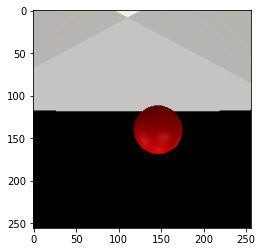

In [42]:
imshow(img)

# Question 2

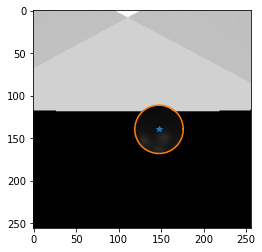

In [43]:
# Convert to gray scale
circles_imgs = []
for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0)
    if circles is not None:
        Cs = []
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # In pixels
            radius = circle[2]  # In pixels
            xa, _ = center + radius
            xb, _ = center - radius
            if xa < 264 and xb > 0 and center[1] < 180 and center[1] > 120:
                Cs.append(circle)
        circles_imgs.append(Cs)
    
# plot circle
s = linspace(0,2*pi,100)
cx = cos(s)*radius + center [0]
cy = sin(s)*radius + center [1]
# Plot center
plot(center[0], center[1], '*')
        
plot(cx,cy)
imshow(gray, cmap='gray')

# Question 3

In [35]:
u0, v0 = 132, 132

# number of pixels in x-axis
npx = 264

fov = 60  # degrees

Xs = []
Ys = []
Rs = []

for circles, ori in zip(circles_imgs, oris):
    for circle in circles:
        center = (circle[0], circle[1])  # In pixels
        radius = circle[2]  # In pixels
        k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
        xmax = npx / (2.* k) # maximum value in the x-axis (in meters)
        zc = xmax / tan(pi/6) # Distance to the center of the sphere (z-axis coordinate)
        xc = (center[0] - u0) / k # Location of the sphere in the x-axis coordinate
        # Convert to world frame by rotation matrix [cos(theta), -sin(theta)][sin(theta), cos(theta)]
        theta = ori[2] - pi/2
        Ysi = xc * sin(theta) + zc * cos(theta)
        Xsi = xc * cos(theta) + zc * -sin(theta)
        Ys.append(Ysi)
        Xs.append(Xsi)
        Rs.append(radius)
        print(theta/pi*180, Xsi, Ysi, radius)
print(len(Xs), len(Ys), len(Rs))

-5.9929557374527604 -0.00802872619599998 3.7247160195427527 46.3
-32.651464105768504 4.770754808854431 4.375685288311878 27.4
-59.164407482492926 5.225969914678067 4.680730436449605 24.9
-85.5410813281996 3.1777472924028056 0.018364187373106022 54.1
-111.53232162262694 4.943380905425601 -3.0965061023910514 29.9
-137.08398417556376 4.8561335663680305 -3.03777495827854 31.0
-162.85993648046548 1.6993910060475104 -7.210491821951117 23.2
-188.61077417978905 1.664736548060066 -7.478249050825872 24.0
-215.68190110605443 -2.4257016552041932 -3.589028841932965 39.6
-215.68190110605443 -4.996373823854716 -4.789278645445559 25.2
-242.12085304350012 -5.835006800580069 -5.340527853826255 22.4
-268.7899960163536 -5.495619012184265 0.7587189485641226 31.3
-268.7899960163536 -10.790529455762291 0.1731185743934757 15.9
64.79759051884977 -5.3321303528547555 0.7991451620469547 33.2
38.27893027379004 -3.6507721602764365 4.523576602912202 29.5
12.43387011486614 0.0013791411289533206 3.650855110566996 48.1

# Question 4

### Grid representation

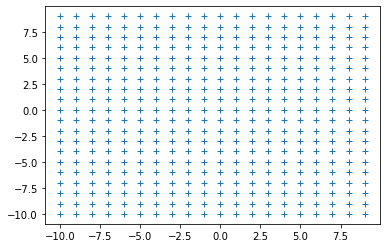

In [36]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

Draw each cell independently

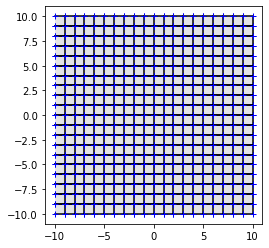

In [37]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

## Use the measurement

In [38]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief

# For each cell, check if the circle is in it.
for i in range(n*n):
    x, y = grid_x[i], grid_y[i]
    flag = 1
    for Xsi, Ysi, radius in zip(Xs, Ys, Rs):
        k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
        # Corners of the cell
        X, Y = points_cell(x, y, cell_w)
        # check based on the ecuclidean distance
        dist = sqrt((Xsi - X)**2 + (Ysi - Y)**2)
    
        # Check if At least one of the borders is within the sphere
        if((dist < radius/k).any()):
            po = 0.8  # P(mi/zt) probability of having an obstacle 
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li  # P(mi/zt) 
            flag = 0
            break
    if flag: # No boreders with the sphere
        po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle
        li = log(po / (1-po)) + gmap[i] - l0
        gmap[i] = li
           
    pass

# gmap

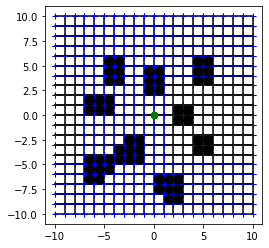

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()